# Example: mesh a delineated watershed

Here we mesh the Coal Creek watershed as an example of how to pull data in from default locations and generate a fully functional mesh with sufficient subsurface structure.

This workflow pulls a range of datasets:

* `NHD Plus` for river network
* `NED` for elevation
* `NLCD` for land cover/transpiration/rooting depths
* `NRCS` soils data for soil types
* `GLYHMPS` geology data for geology types
* `SoilGrids` for depth to bedrock

In [4]:
import os,sys
import numpy as np
import pandas as pd
import scipy
import scipy.spatial
from scipy.ndimage import gaussian_filter
from matplotlib import pyplot as plt
from matplotlib import cm as pcm
import matplotlib.colors as mcolors
import shapely
import logging
import pandas
pandas.options.display.max_columns = None


import workflow
import workflow.source_list
import workflow.ui
import workflow.colors
import workflow.condition
import workflow.mesh
import workflow.split_hucs

workflow.ui.setup_logging(1,None)
figsize = (6,6)
figsize_3d = (8,6)

In [8]:
watershed_shapefile = '../data/hydrologic_units/others/CoalCreek/CoalCreek.shp'

## Sources and setup

Next we set up the source watershed and coordinate system and all data sources for our mesh.  We will use the CRS that is included in the shapefile.

In [9]:
# specify the input shapefile and a hint as to what HUC it is in.
# watershed_shapefile = watershed_shapefile



logging.info("")
logging.info("Meshing shape: {}".format(watershed_shapefile))
logging.info("="*30)

# get the shape and crs of the shape
crs, watershed = workflow.get_split_form_shapes(watershed_shapefile)

2021-04-21 10:12:33,116 - root - INFO: 
2021-04-21 10:12:33,117 - root - INFO: Meshing shape: /Users/shua784/OneDrive - PNNL/github/watershed-workflow/data/hydrologic_units/EastTaylor/CoalCreek.shp
2021-04-21 10:12:33,118 - root - INFO: ==============================
2021-04-21 10:12:33,118 - root - INFO: 
2021-04-21 10:12:33,119 - root - INFO: Preprocessing Shapes
2021-04-21 10:12:33,119 - root - INFO: ------------------------------
2021-04-21 10:12:33,119 - root - INFO: loading file: "/Users/shua784/OneDrive - PNNL/github/watershed-workflow/data/hydrologic_units/EastTaylor/CoalCreek.shp"


A wide range of data sources are available; here we use the defaults except for using NHD Plus for watershed boundaries and hydrography (the default is NHD, which is lower resolution and therefore smaller download sizes).

In [10]:
# set up a dictionary of source objects
sources = workflow.source_list.get_default_sources()
sources['hydrography'] = workflow.source_list.hydrography_sources['NHD Plus']
sources['HUC'] = workflow.source_list.huc_sources['NHD Plus']
workflow.source_list.log_sources(sources)

2021-04-21 10:12:35,946 - root - INFO: Using sources:
2021-04-21 10:12:35,947 - root - INFO: --------------
2021-04-21 10:12:35,947 - root - INFO: HUC: National Hydrography Dataset Plus High Resolution (NHDPlus HR)
2021-04-21 10:12:35,947 - root - INFO: hydrography: National Hydrography Dataset Plus High Resolution (NHDPlus HR)
2021-04-21 10:12:35,948 - root - INFO: DEM: National Elevation Dataset (NED)
2021-04-21 10:12:35,948 - root - INFO: soil structure: National Resources Conservation Service Soil Survey (NRCS Soils)
2021-04-21 10:12:35,949 - root - INFO: geologic structure: GLHYMPS version 2.0
2021-04-21 10:12:35,949 - root - INFO: land cover: National Land Cover Database (NLCD) Layer: NLCD_2016_Land_Cover_L48
2021-04-21 10:12:35,950 - root - INFO: soil thickness: None
2021-04-21 10:12:35,950 - root - INFO: meteorology: DayMet 1km


## Generate the surface mesh

First we'll generate the flattened, 2D triangulation, which builds on hydrography data.  Then we download a digital elevation map from the National Elevation Dataset, and extrude that 2D triangulation to a 3D surface mesh based on interpolation between pixels of the DEM.

**Option 1: given huc4 find the huc of the watershed shape**

In [11]:
hint = '1402'  # hint: HUC 4 containing this shape.  
               # This is necessary to avoid downloading all HUCs to search for this shape

# find what HUC our shape is in
huc = workflow.find_huc(sources['HUC'], watershed.exterior(), crs, hint, shrink_factor=0.1)
logging.info("Found watershed in HUC: {}".format(huc))

**Option 2: provide the huc8 or huc12 number**

In [12]:
huc = "140200010204" # provide the HUC8/HUC12 for NHD or HUC4 for NHDPlus that includes that watershed

### Get river network

This will download river network from NHD, NHD Plus database, and simplify and prune rivers to construct a tree-like data structure.

In [13]:
simplify = 30 # length scale to target average edge

rivers = True
if rivers:
    # download/collect the river network within that shape's bounds
    _, reaches = workflow.get_reaches(sources['hydrography'], huc, 
                                      watershed.exterior().bounds, crs)
    # simplify and prune rivers not IN the shape, constructing a tree-like data structure
    # for the river network
    rivers = workflow.simplify_and_prune(watershed, reaches, filter=True, simplify=simplify, cut_intersections=True,
                                         ignore_small_rivers=2, prune_by_area_fraction=0.01
                                        )

else:
    rivers = list()
    workflow.split_hucs.simplify(watershed, simplify)

2021-04-21 10:17:06,229 - root - INFO: 
2021-04-21 10:17:06,229 - root - INFO: Preprocessing Hydrography
2021-04-21 10:17:06,229 - root - INFO: ------------------------------
2021-04-21 10:17:06,230 - root - INFO: Loading streams in HUC 140200010204
2021-04-21 10:17:06,230 - root - INFO:          and/or bounds (317251.2640131897, 4299711.408984916, 328473.7039815487, 4307062.45088187)
2021-04-21 10:17:06,232 - root - INFO: Using Hydrography file "/Users/shua784/github/workflow-test/examples/data/hydrography/NHDPlus_H_1402_GDB/NHDPlus_H_1402.gdb"
2021-04-21 10:17:07,202 - root - INFO:   found 201 reaches
2021-04-21 10:17:58,900 - root - INFO: 
2021-04-21 10:17:58,900 - root - INFO: Simplifying and pruning
2021-04-21 10:17:58,901 - root - INFO: ------------------------------
2021-04-21 10:17:58,901 - root - INFO: Filtering rivers outside of the HUC space
2021-04-21 10:17:58,902 - root - INFO:   ...filtering
2021-04-21 10:17:58,938 - root - INFO:   filtered from 201 to 118 reaches.
2021-0

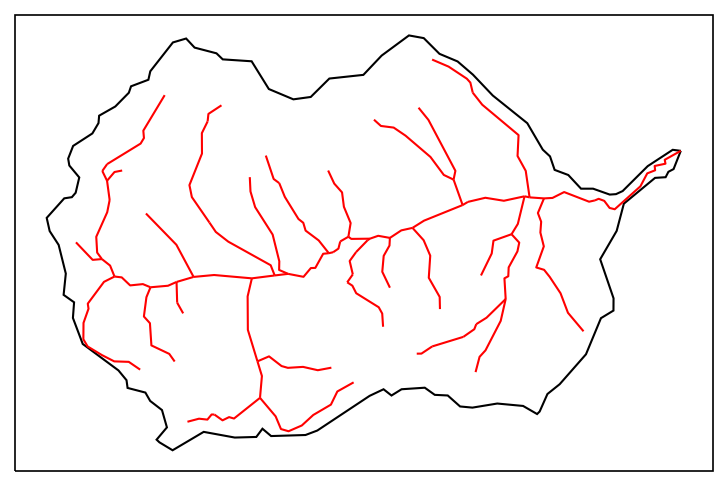

In [14]:
# plot what we have so far -- an image of the HUC and its stream network
fig = plt.figure(figsize=figsize)
ax = workflow.plot.get_ax(crs, fig)

workflow.plot.hucs(watershed, crs, ax=ax, color='k', linewidth=1)
workflow.plot.rivers(rivers, crs, ax=ax, color='red', linewidth=1)

plt.show()

### Generate meshes using river network and watershed shape

- triangulation refinement:
Refine triangles if their area (in m^2) is greater than A(d), where d is the 
distance from the triangle centroid to the nearest stream.
A(d) is a piecewise linear function -- A = A0 if d <= d0, A = A1 if d >= d1, and
linearly interpolates between the two endpoints.

2021-04-21 10:20:11,162 - root - INFO: 
2021-04-21 10:20:11,163 - root - INFO: Meshing
2021-04-21 10:20:11,163 - root - INFO: ------------------------------
2021-04-21 10:20:11,165 - root - INFO: Triangulating...
2021-04-21 10:20:11,166 - root - INFO:    97 points and 97 facets
2021-04-21 10:20:11,166 - root - INFO:  checking graph consistency
2021-04-21 10:20:11,166 - root - INFO:  tolerance is set to 1
2021-04-21 10:20:11,168 - root - INFO:  building graph data structures
2021-04-21 10:20:11,169 - root - INFO:  triangle.build...
2021-04-21 10:20:13,615 - root - INFO:   ...built: 4633 mesh points and 9040 triangles
2021-04-21 10:20:13,616 - root - INFO: Plotting triangulation diagnostics
2021-04-21 10:20:14,349 - root - INFO:   min area = 1419.6597900390625
2021-04-21 10:20:14,349 - root - INFO:   max area = 49289.118408203125


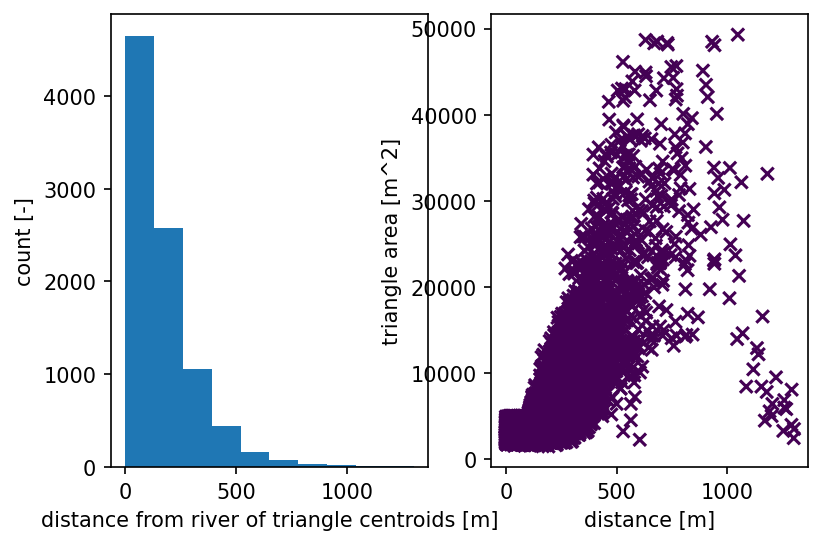

In [15]:
d0 = 100; d1 = 500
A0 = 5000; A1 = 50000 # [100, 310]m

# Refine triangles if they get too acute
min_angle = 32 # degrees

# make 2D mesh
mesh_points2, mesh_tris, areas, distances = workflow.triangulate(watershed, rivers, 
                                               refine_distance=[d0,A0,d1,A1],
                                               refine_min_angle=min_angle,
                                               diagnostics=True,
                                               )

### Map mesh to DEM

This will download DEM from USGS NED and elevate the triangle nodes to the DEM.

2021-04-21 10:24:02,687 - root - INFO: 
2021-04-21 10:24:02,688 - root - INFO: Preprocessing Raster
2021-04-21 10:24:02,688 - root - INFO: ------------------------------
2021-04-21 10:24:02,689 - root - INFO: collecting raster
2021-04-21 10:24:02,788 - root - INFO: Collecting DEMs to tile bounds: [-107.11634327399999, 38.817702882000034, -106.96736783099998, 38.90466788700003]
2021-04-21 10:24:02,789 - root - INFO:   Need:
2021-04-21 10:24:02,789 - root - INFO:     /Users/shua784/github/workflow-test/examples/data/dem/USGS_NED_1as_n39_w108.img
2021-04-21 10:24:02,790 - root - INFO:     /Users/shua784/github/workflow-test/examples/data/dem/USGS_NED_1as_n39_w107.img
2021-04-21 10:24:02,791 - root - INFO: source files already exist!
2021-04-21 10:24:02,809 - root - INFO: Got raster of shape: (314, 537)
2021-04-21 10:24:02,810 - root - INFO: Raster bounds: (-107.11634327399999, 38.90466788700003, -106.9671766073332, 38.817445664777736)


<Figure size 900x600 with 0 Axes>

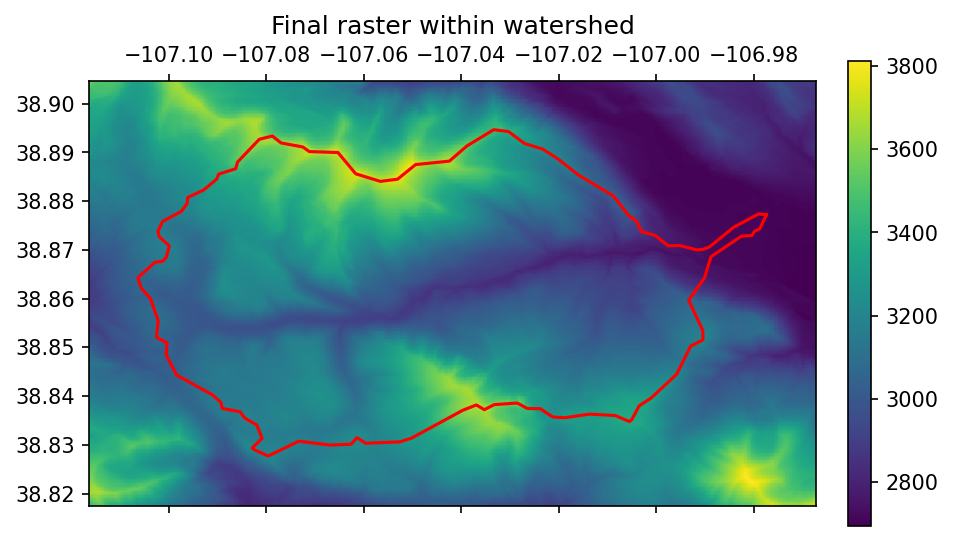

In [21]:
dem_profile, dem = workflow.get_raster_on_shape(sources['DEM'], watershed.exterior(), crs, 
                                                plot = True
                                               )

In [18]:
mesh_points3 = workflow.elevate(mesh_points2, crs, dem, dem_profile)

2021-04-21 10:22:32,418 - root - INFO: 
2021-04-21 10:22:32,419 - root - INFO: Elevating Triangulation to DEM
2021-04-21 10:22:32,420 - root - INFO: ------------------------------


### plot surface meshes

Plotting the resulting mesh can be done in a variety of ways, including both 3D plots and mapview.  We show both here, but hereafter use mapview plots as they are a bit clearer (if not so flashy)...

[Text(4299000.0, 0, ''),
 Text(4300000.0, 0, ''),
 Text(4301000.0, 0, ''),
 Text(4302000.0, 0, ''),
 Text(4303000.0, 0, ''),
 Text(4304000.0, 0, ''),
 Text(4305000.0, 0, ''),
 Text(4306000.0, 0, ''),
 Text(4307000.0, 0, ''),
 Text(4308000.0, 0, '')]

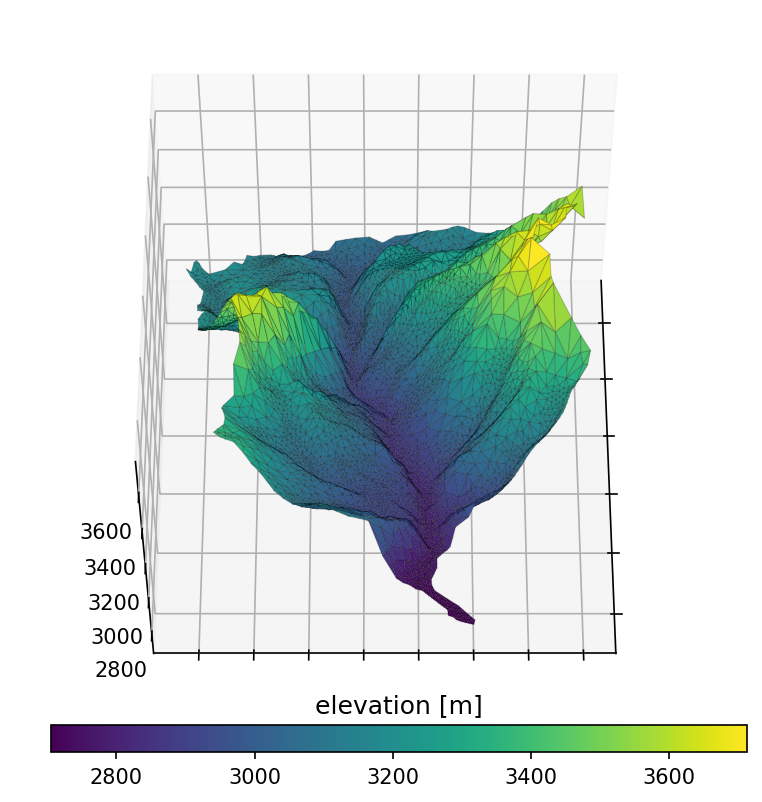

In [19]:
# plot the resulting surface mesh
fig = plt.figure(figsize=figsize_3d)
ax = workflow.plot.get_ax('3d', fig, window=[0.0,0.2,1,0.8])
cax = fig.add_axes([0.23,0.18,0.58,0.03])

mp = ax.plot_trisurf(mesh_points3[:,0], mesh_points3[:,1], mesh_points3[:,2], 
                     triangles=mesh_tris, cmap='viridis', 
                     edgecolor=(0,0,0,.2), linewidth=0.5)
cb = fig.colorbar(mp, orientation="horizontal", cax=cax)

t = cax.set_title('elevation [m]')
ax.view_init(55,0)
ax.set_xticklabels(list())
ax.set_yticklabels(list())

#fig.savefig('watershed_dem_3d')

(316690.15495, 329034.55405000004)
(4299344.330884162, 4307420.049100754)


Text(0.5, 1.0, 'elevation [m]')

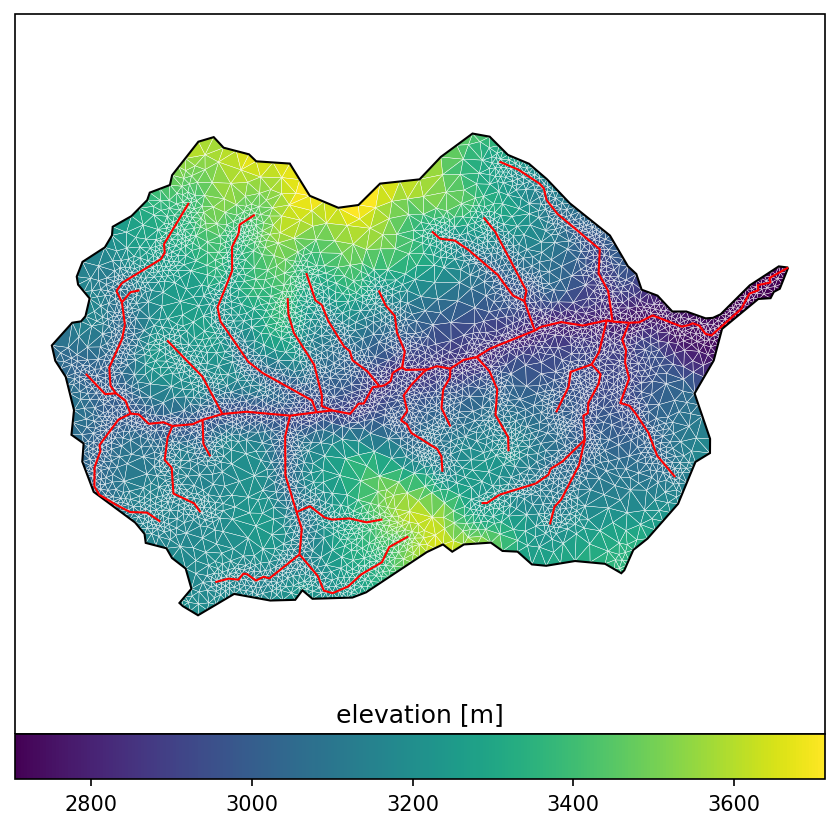

In [20]:
# plot the resulting surface mesh
fig = plt.figure(figsize=figsize)
ax = workflow.plot.get_ax(crs, fig, window=[0.05,0.1,0.9,0.8])
#ax2 = workflow.plot.get_ax(crs,fig, window=[0.65,0.05,0.3,0.5])
# ax2 = ax.inset_axes([0.65,0.05,0.3,0.5])
cbax = fig.add_axes([0.05,0.05,0.9,0.05])

xlim = (275900., 276400.)
ylim = (3882300., 3883000.)

mp = workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax, 
                                 color='elevation', edgecolor='white', linewidth=0.2)
cbar = fig.colorbar(mp, orientation="horizontal", cax=cbax)
workflow.plot.hucs(watershed, crs, ax=ax, color='k', linewidth=1)
workflow.plot.rivers(rivers, crs, ax=ax, color='red', linewidth=1)
ax.set_aspect('equal', 'datalim')

# mp2 = workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax2, 
#                                  color='elevation', edgecolor='white', linewidth=0.2)
# workflow.plot.hucs(watershed, crs, ax=ax2, color='k', linewidth=1)
# workflow.plot.rivers(rivers, crs, ax=ax2, color='red', linewidth=1.5)
# ax2.set_xlim(xlim)
# ax2.set_ylim(ylim)
# ax2.set_xticks([])
# ax2.set_yticks([])

# ax.indicate_inset_zoom(ax2, edgecolor='k')


print(ax.get_xlim())
print(ax.get_ylim())
cbar.ax.set_title('elevation [m]')
# fig.savefig('watershed_dem2')

### construct 2d mesh 

In [22]:
m2 = workflow.mesh.Mesh2D(mesh_points3.copy(), list(mesh_tris))

### Hydrologically condition the mesh

Conditions a mesh, in place, by removing artificial pits. 

2021-04-21 10:24:23,754 - root - INFO: max diff = 42.99142578277724 


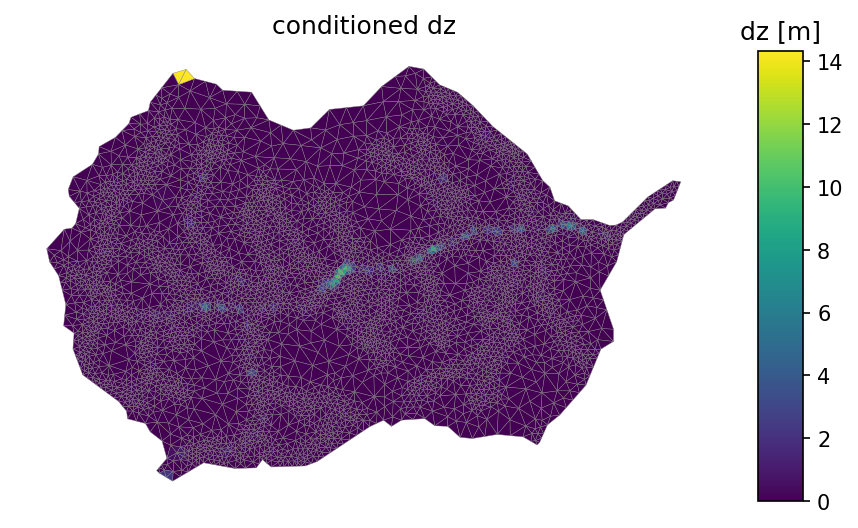

In [23]:
# hydrologically condition the mesh, removing pits
workflow.condition.condition(m2)

# plot the change between the two meshes
diff = np.copy(mesh_points3)
diff[:,2] = m2.points[:,2] - mesh_points3[:,2] 
logging.info(f"max diff = {np.abs(diff[:,2]).max()} ")
fig, ax = workflow.plot.get_ax(crs, figsize=figsize)
cbax = fig.add_axes([.95,0.25,0.05,0.5])

mp = workflow.plot.triangulation(diff, m2.conn, crs, color='elevation', edgecolors='gray', 
                            linewidth=0.2, ax=ax)
cbar = fig.colorbar(mp, orientation="vertical", cax=cbax)
cbar.ax.set_title('dz [m]')
ax.axis('off')
ax.set_title('conditioned dz')
plt.show()

## Surface properties

Meshes interact with data to provide forcing, parameters, and more in the actual simulation.  Specifically, we need vegetation type on the surface to provide information about transpiration and subsurface structure to provide information about water retention curves, etc.

We'll start by downloading and collecting land cover from the NLCD dataset, and generate sets for each land cover type that cover the surface.  Likely these will be some combination of grass, deciduous forest, coniferous forest, and mixed.

In [24]:
# download the NLCD raster
lc_profile, lc_raster = workflow.get_raster_on_shape(sources['land cover'], 
                                                     watershed.exterior(), crs)

# resample the raster to the triangles
lc = workflow.values_from_raster(m2.centroids(), crs, lc_raster, lc_profile)

# what land cover types did we get?
logging.info('Found land cover dtypes: {}'.format(lc.dtype))
logging.info('Found land cover types: {}'.format(set(lc)))


2021-04-21 10:24:41,664 - root - INFO: 
2021-04-21 10:24:41,665 - root - INFO: Preprocessing Raster
2021-04-21 10:24:41,665 - root - INFO: ------------------------------
2021-04-21 10:24:41,665 - root - INFO: collecting raster
2021-04-21 10:24:41,678 - root - INFO: CRS: PROJCS["Albers_Conical_Equal_Area",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["meters",1],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
2021-04-21 10:24:41,791 - root - INFO: Got raster of shape: (245, 374)
2021-04-21 10:24:41,792 - root - INFO: Raster bounds: (-952

In [25]:
# -- get the NLCD colormap which uses official NLCD colors and labels
nlcd_indices, nlcd_cmap, nlcd_norm, nlcd_ticks, nlcd_labels = \
                workflow.colors.generate_nlcd_colormap(lc)

(316690.15495, 329034.55405000004, 4299344.3309, 4307420.0490999995)

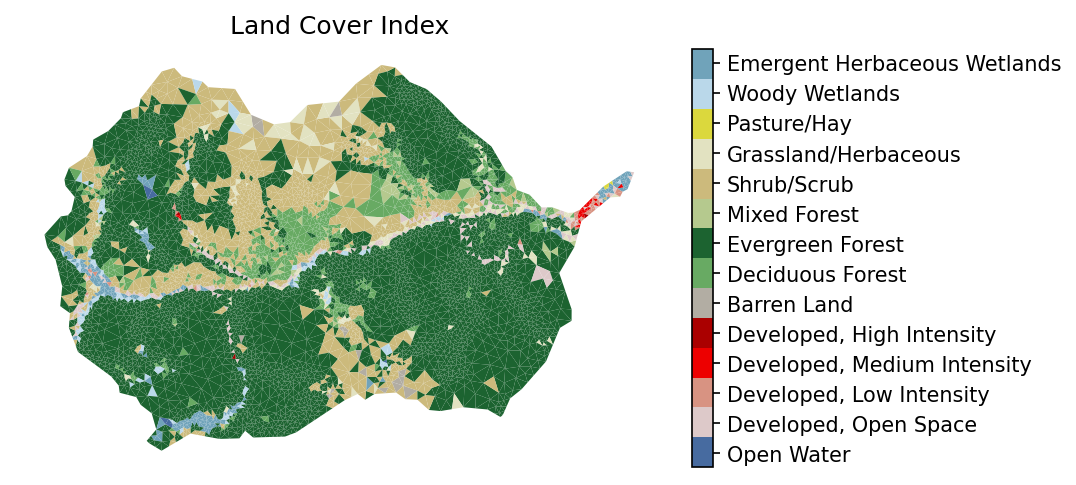

In [26]:
# plot the image
fig = plt.figure(figsize=figsize)
ax = workflow.plot.get_ax(crs, fig)

polys = workflow.plot.mesh(m2, crs, ax=ax, color=lc, cmap=nlcd_cmap, norm=nlcd_norm, edgecolor='none', 
                                     facecolor='color', linewidth=0.5)

workflow.colors.colorbar_index(ncolors=len(np.unique(lc)), cmap=nlcd_cmap, labels = nlcd_labels) 

ax.set_title("Land Cover Index")
ax.axis('off')
# fig.tight_layout()
# fig.savefig(fig_land_cover, dpi = 300, transparent = True)

## Subsurface properties

Get soil structure from SSURGO.  By soil structure, here we calculate, for each formation identified in SSURGO, a soil depth, porosity, permeability, and percent sand/silt/clay (which are then handed off to Rosetta to get a van Genuchten model). 

Below this soil we also identify a geologic layer provided by GLHYMPS.  This provides information about the deeper subsurface.

### SSURGO Soil Properties

In [43]:
# download the NRCS soils data as shapes and project it onto the mesh
import matplotlib.cm

# -- download the shapes
target_bounds = watershed.exterior().bounds
logging.info('target bounds: {}'.format(target_bounds))
soil_profile, soil_survey, soil_survey_props = workflow.get_shapes(sources['soil structure'], target_bounds, crs, properties=True)

# -- determine the NRCS mukey for each soil unit; this uniquely identifies soil 
#    properties
soil_ids = np.array([shp.properties['id'] for shp in soil_survey], np.int32)

# -- color a raster by the polygons (this makes identifying a triangle's value much 
#    more efficient)
soil_color_raster, soil_color_profile, img_bounds = \
            workflow.color_raster_from_shapes(target_bounds, 10, soil_survey,
                                              soil_ids, crs)

# -- resample the raster to the triangles
soil_color = workflow.values_from_raster(m2.centroids(), crs, 
                                         soil_color_raster, soil_color_profile)

2021-04-21 10:33:50,524 - root - INFO: target bounds: (317251.2640131897, 4299711.408984916, 328473.4449929282, 4307052.970983125)
2021-04-21 10:33:50,524 - root - INFO: 
2021-04-21 10:33:50,525 - root - INFO: Preprocessing Shapes
2021-04-21 10:33:50,525 - root - INFO: ------------------------------
2021-04-21 10:33:50,725 - root - INFO: Attempting to download source for target '/Users/shua784/github/workflow-test/examples/data/soil_structure/SSURGO/SSURGO_-107.1073_38.8271_-106.9759_38.8957.gml'
../../workflow-test/workflow/sources/manager_nrcs.py:272: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  shapes = [_flip(s) for s in fid]
2021-04-21 10:33:50,739 - root - INFO:   Found 103 shapes.
2021-04-21 10:33:50,740 - root - INFO:   and crs: EPSG:4326
2021-04-21 10:33:50,752 - root - INFO: found 33 unique MUKEYs.
2021-04-21 10:33:52,471 - root - INFO: Running Rosetta for van Genutchen parameters
2021-04-21 10:

Select only the soils within the watershed

In [54]:
soil_survey_props.set_index('mukey', inplace = True, drop = False)

soil_survey_props = soil_survey_props.loc[np.unique(soil_color), :]

(316690.15495, 329034.55405000004, 4299344.3309, 4307420.0490999995)

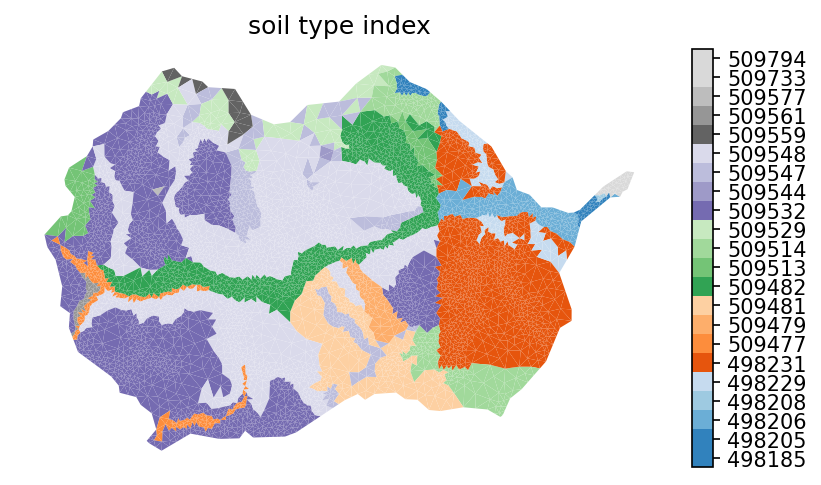

In [28]:
indices, cmap, norm, ticks, labels = workflow.colors.generate_indexed_colormap(soil_color, cmap = 'tab20c')

# plot the soil mukey
fig = plt.figure(figsize=figsize)
ax = workflow.plot.get_ax(crs, fig)

mp = workflow.plot.mesh(m2, crs, ax=ax, facecolor='color',
                        linewidth=0, color=soil_color, 
                        cmap=cmap, norm = norm
                       )

workflow.colors.colorbar_index(ncolors=len(np.unique(soil_color)), cmap=cmap, labels = labels) 

ax.set_title('soil type index')
ax.axis('off')
# fig.savefig('watershed_soils')

Median soil thickness [m] =  1.52


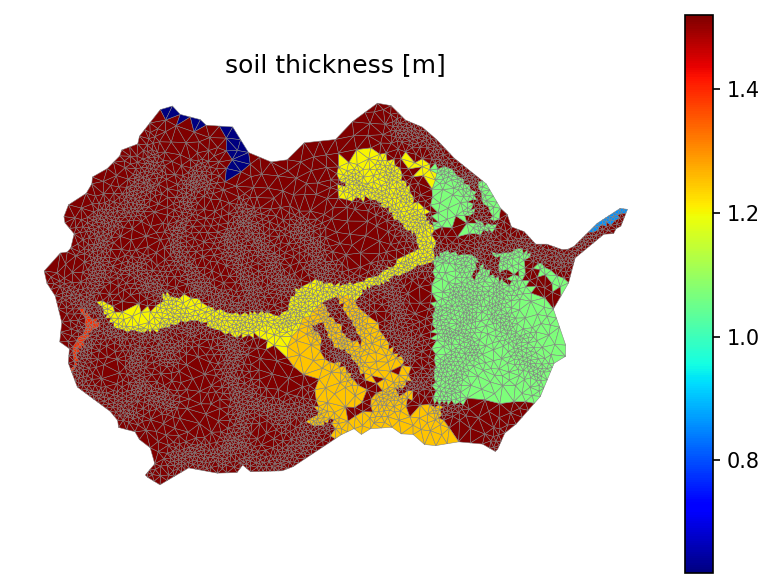

In [45]:
# what do soil thicknesses look like?
fig = plt.figure(figsize=figsize)
iprop = np.empty(soil_color.shape, 'd')
for mukey in soil_survey_props.index:
    iprop[soil_color == mukey] = soil_survey_props.loc[ mukey,'thickness [cm]']

ax = workflow.plot.get_ax(crs, fig)
mp = workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax, 
                                 color=iprop/100, edgecolor='gray', cmap='jet')
# cbar = fig.colorbar(mp)
ax.set_title('soil thickness [m]')
cb = fig.colorbar(mp, fraction=0.04, pad=0.04)
# cb.ax.set_title('[m]')
# cb.set_ticks(nlcd_ticks)
# cb.set_ticklabels(nlcd_labels_fw)
# ax.set_title("Land Cover Index")
ax.axis('off')

print('Median soil thickness [m] = ', np.median(iprop)/100)

# fig.savefig('watershed_soil_thickness')


Median soil thickness [m] =  0.19334978070175438


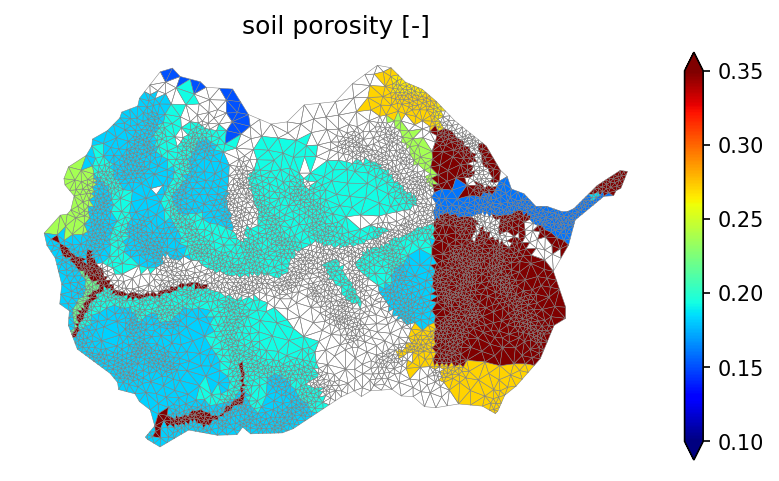

In [46]:
# what do soil thicknesses look like?
fig = plt.figure(figsize=figsize)
iprop = np.empty(soil_color.shape, 'd')
for mukey in soil_survey_props.index:
    iprop[soil_color == mukey] = soil_survey_props.loc[ mukey,'porosity [-]']

ax = workflow.plot.get_ax(crs, fig)
mp = workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax, 
                                 color=iprop, edgecolor='gray', cmap='jet', vmin = 0.1, vmax = 0.35)
# cbar = fig.colorbar(mp)
ax.set_title('soil porosity [-]')
cb = fig.colorbar(mp, fraction=0.04, pad=0.04, extend = "both", shrink = 0.6)
# cb.ax.set_title('[m]')
# cb.set_ticks(nlcd_ticks)
# cb.set_ticklabels(nlcd_labels_fw)
# ax.set_title("Land Cover Index")
ax.axis('off')

print('Median soil thickness [m] = ', np.nanmedian(iprop))

# fig.savefig('watershed_soil_thickness')


Min k [m^2] =  7.0000000000000025e-15


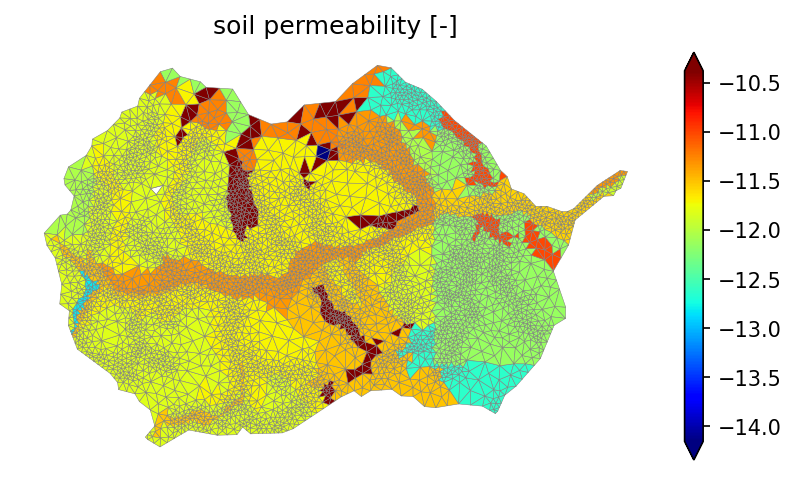

In [63]:
# what do soil thicknesses look like?
fig = plt.figure(figsize=figsize)
iprop = np.empty(soil_color.shape, 'd')
for mukey in soil_survey_props.index:
    iprop[soil_color == mukey] = soil_survey_props.loc[ mukey,'permeability [m^2]']

    
vmin = np.nanmin(np.log10(iprop))
vmax = np.nanmax(np.log10(iprop))
ax = workflow.plot.get_ax(crs, fig)
mp = workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax, 
                                 color=np.log10(iprop), edgecolor='gray', cmap='jet', 
                                 vmin = vmin, vmax = vmax
                                )
# cbar = fig.colorbar(mp)
ax.set_title('soil permeability [-]')
cb = fig.colorbar(mp, fraction=0.04, pad=0.04, extend = "both", shrink = 0.6)
# cb.ax.set_title('[m]')
# cb.set_ticks(nlcd_ticks)
# cb.set_ticklabels(nlcd_labels_fw)
# ax.set_title("Land Cover Index")
ax.axis('off')

print('Min k [m^2] = ', np.nanmin(iprop))

# fig.savefig('watershed_soil_thickness')


### GLYHMPS geologic layer

In [64]:
# extract the GLYHMPS geologic structure data as shapes and project it onto the mesh
target_bounds = watershed.exterior().bounds
logging.info('target bounds: {}'.format(target_bounds))

_, geo_survey, geo_survey_props = workflow.get_shapes(sources['geologic structure'], target_bounds, crs, properties=True)

# -- log the bounds targetted and found
logging.info('shape union bounds: {}'.format(
    shapely.ops.cascaded_union(geo_survey).bounds))

# -- determine the ID for each soil unit; this uniquely identifies formation
#    properties
geo_ids = np.array([shp.properties['id'] for shp in geo_survey], np.int32)

# -- color a raster by the polygons (this makes identifying a triangle's value much 
#    more efficient)
geo_color_raster, geo_color_profile, img_bounds = \
            workflow.color_raster_from_shapes(target_bounds, 10, geo_survey,
                                              geo_ids, crs)

# -- resample the raster to the triangles
geo_color = workflow.values_from_raster(m2.centroids(), crs, 
                                         geo_color_raster, geo_color_profile)


2021-04-21 10:52:52,529 - root - INFO: target bounds: (317251.2640131897, 4299711.408984916, 328473.4449929282, 4307052.970983125)
2021-04-21 10:52:52,529 - root - INFO: 
2021-04-21 10:52:52,530 - root - INFO: Preprocessing Shapes
2021-04-21 10:52:52,530 - root - INFO: ------------------------------
2021-04-21 10:52:52,651 - fiona.ogrext - INFO: Failed to auto identify EPSG: 7
../../workflow-test/workflow/sources/manager_shape.py:76: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  shps = [s for (i,s) in fid.items(bbox=bounds)]
2021-04-21 10:53:03,880 - root - INFO: shape union bounds: (309452.03384970897, 4277422.824854819, 338890.05886956863, 4329709.205645651)
2021-04-21 10:53:03,881 - root - INFO: Coloring shapes onto raster:
2021-04-21 10:53:03,881 - root - INFO:   target_bounds = (317251.2640131897, 4299711.408984916, 328473.4449929282, 4307052.970983125)
2021-04-21 10:53:03,882 - root - INFO:   out_bou

In [70]:
geo_survey_props.set_index('id', inplace = True, drop = False)

geo_survey_props = geo_survey_props.loc[np.unique(geo_color), :]

(316690.15495, 329034.55405000004, 4299344.3309, 4307420.0490999995)

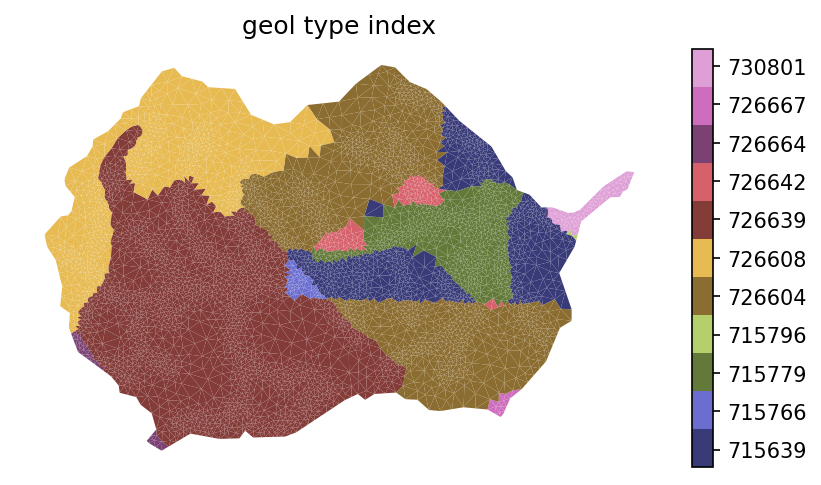

In [65]:
indices, cmap, norm, ticks, labels = workflow.colors.generate_indexed_colormap(geo_color, cmap = 'tab20b')

# plot the geologic formation id
fig = plt.figure(figsize=figsize)
ax = workflow.plot.get_ax(crs, fig)

mp = workflow.plot.mesh(m2, crs, ax=ax, facecolor='color',
                                 linewidth=0, color=geo_color, 
                        cmap=cmap, norm = norm
                        )

workflow.colors.colorbar_index(ncolors=len(np.unique(geo_color)), cmap=cmap, labels = labels) 

ax.set_title('geol type index')
ax.axis('off')
# print(geo_survey_props)

# fig.savefig('watershed_geology')

(0.0, 1.0, 0.0, 1.0)

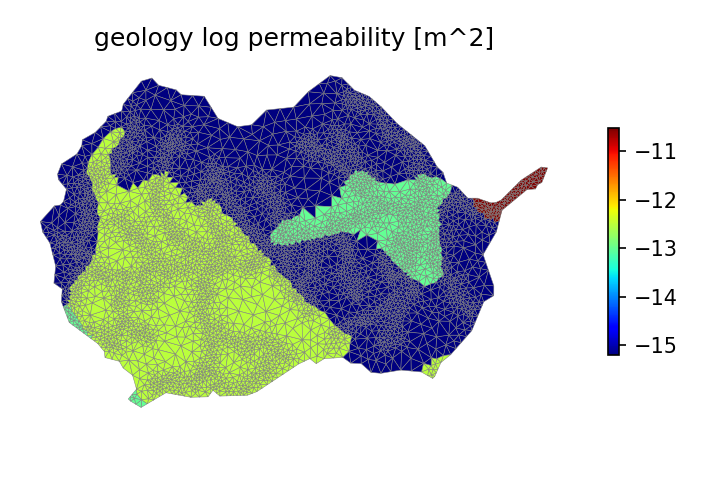

In [75]:
# averaging permeability is a tricky beast.  we average in log space, check that unit conversions make sense
fig, ax = plt.subplots(1,1)
iprop = np.empty(geo_color.shape, 'd')

for i in geo_survey_props.index:
    iprop[geo_color == i] = geo_survey_props.loc[i, 'permeability [m^2]']

vmin = np.nanmin(np.log10(iprop))
vmax = np.nanmax(np.log10(iprop))
# print(f'min = {pmin}, max = {pmax}')

ax1 = workflow.plot.get_ax(crs, fig, nrow=1, ncol=1)
mp = workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax1, 
                                 color=np.log10(iprop), edgecolor='gray', cmap='jet',
                                vmin=vmin, vmax=vmax)
cbar = fig.colorbar(mp, shrink=0.5)
ax1.set_title('geology log permeability [m^2]')
ax1.axis('off')

# ax2 = workflow.plot.get_ax(crs, fig, nrow=1, ncol=2, index=2)
# mp = workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax2, 
#                                  color=np.log10(soil_perm_rosetta), edgecolor='gray', cmap='jet',
#                                 vmin=pmin, vmax=pmax)
# cbar = fig.colorbar(mp, shrink=0.5)
# ax2.set_title('log permeability (Rosetta) [m^2]')
ax.axis('off')


# # fig.savefig('watershed_permeability')

(0.0, 1.0, 0.0, 1.0)

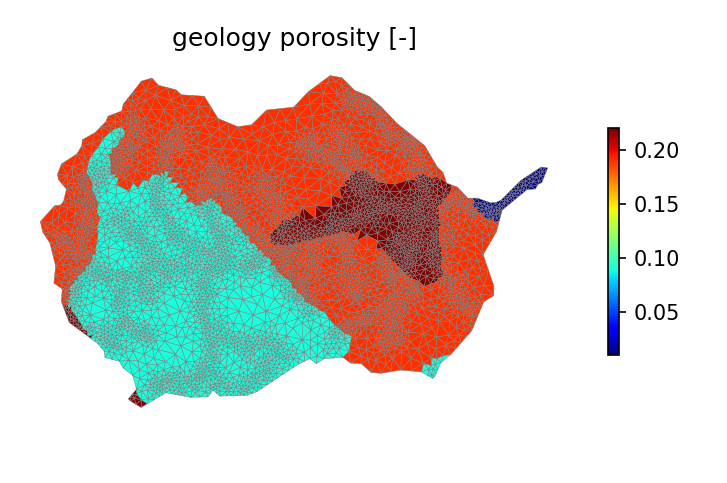

In [77]:
# averaging permeability is a tricky beast.  we average in log space, check that unit conversions make sense
fig, ax = plt.subplots(1,1)
iprop = np.empty(geo_color.shape, 'd')

for i in geo_survey_props.index:
    iprop[geo_color == i] = geo_survey_props.loc[i, 'porosity [-]']

vmin = np.nanmin(iprop)
vmax = np.nanmax(iprop)
# print(f'min = {pmin}, max = {pmax}')

ax1 = workflow.plot.get_ax(crs, fig, nrow=1, ncol=1)
mp = workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax1, 
                                 color=iprop, edgecolor='gray', cmap='jet',
                                vmin=vmin, vmax=vmax)
cbar = fig.colorbar(mp, shrink=0.5)
ax1.set_title('geology porosity [-]')
ax1.axis('off')

# ax2 = workflow.plot.get_ax(crs, fig, nrow=1, ncol=2, index=2)
# mp = workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax2, 
#                                  color=np.log10(soil_perm_rosetta), edgecolor='gray', cmap='jet',
#                                 vmin=pmin, vmax=pmax)
# cbar = fig.colorbar(mp, shrink=0.5)
# ax2.set_title('log permeability (Rosetta) [m^2]')
ax.axis('off')


# # fig.savefig('watershed_permeability')

## get bedrock depth

Download global depth to bedrock at 250 m resolution from [soilgrids](http://globalchange.bnu.edu.cn/research/dtb.jsp).

In [78]:
DTB_profile, DTB_raster = workflow.get_raster_on_shape("/Path/to/Global_absoluteDTB_M_250m_ll.tif", watershed.exterior(), crs, nodata=-99999)

2021-04-21 12:31:09,813 - root - INFO: 
2021-04-21 12:31:09,814 - root - INFO: Preprocessing Raster
2021-04-21 12:31:09,814 - root - INFO: ------------------------------
2021-04-21 12:31:09,814 - root - INFO: loading file: "/Users/shua784/OneDrive - PNNL/Projects/Columbia_Basin/Reach_domain_QGIS/global/depth-to-bedrock/Global_absoluteDTB_M_250m_ll.tif"
2021-04-21 12:31:09,815 - root - INFO: collecting raster
2021-04-21 12:31:09,957 - root - INFO: Got raster of shape: (33, 63)
2021-04-21 12:31:09,957 - root - INFO: Raster bounds: (-107.108344996, 38.895007756, -106.977095017, 38.826257767)


In [79]:
# resample the raster to the triangles
DTB_raster = DTB_raster/100 #convert from cm to m
DTB_mesh = workflow.values_from_raster(m2.centroids(), crs, DTB_raster, DTB_profile)

In [80]:
logging.info(f'minimum depth-to-bedrock: {np.nanmin(DTB_mesh)} m')
logging.info(f'maximum depth-to-bedrock: {np.nanmax(DTB_mesh)} m')

2021-04-21 12:31:11,368 - root - INFO: minimum depth-to-bedrock: 3.16 m
2021-04-21 12:31:11,369 - root - INFO: maximum depth-to-bedrock: 26.39 m


### plot depth to bedrock

In [81]:
DTB_3d = workflow.elevate(mesh_points2, crs, DTB_raster, DTB_profile)

2021-04-21 12:31:14,263 - root - INFO: 
2021-04-21 12:31:14,264 - root - INFO: Elevating Triangulation to DEM
2021-04-21 12:31:14,264 - root - INFO: ------------------------------


(316690.15495, 329034.55405000004)
(4299344.330884162, 4307420.049100754)


Text(0.5, 1.0, 'DTB [m]')

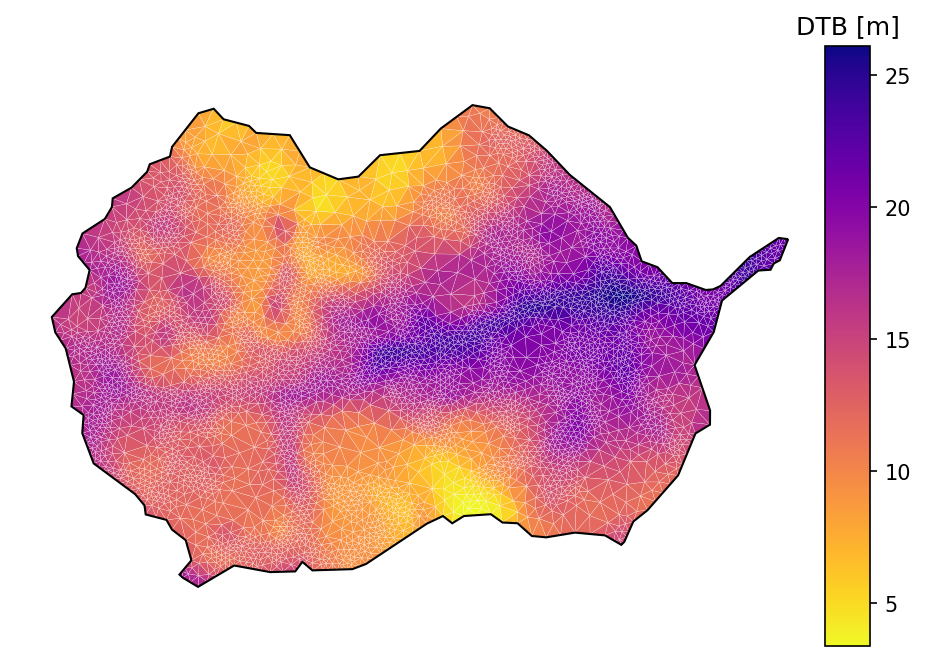

In [82]:
# plot the resulting surface mesh
fig = plt.figure(figsize=(6,5))
ax = workflow.plot.get_ax(crs, fig, window=[0.05,0.1,0.9,0.8])
cbax = fig.add_axes([.95,0.1,0.05,0.8])

mp = workflow.plot.triangulation(DTB_3d, mesh_tris, crs, ax=ax, 
                                 color='elevation', cmap = 'plasma_r', edgecolor='white', linewidth=0.1)
cbar = fig.colorbar(mp, orientation="vertical", cax=cbax)
workflow.plot.hucs(watershed, crs, ax=ax, color='k', linewidth=1)

ax.set_aspect('equal', 'datalim')
ax.axis('off')
# add scalebar, use 1 for UTM coordinates, the default unit is "m"
# scalebar1 = ScaleBar(1, location = "lower left")
# ax.add_artist(scalebar1)

print(ax.get_xlim())
print(ax.get_ylim())
cbar.ax.set_title('DTB [m]')


## Mesh extrusion

Given the surface mesh and material IDs on both the surface and subsurface, we can extrude the surface mesh in the vertical to make a 3D mesh.

First, all integer IDs in Exodus files must be unique.  This includes Material IDs, side sets, etc.  We create the Material ID map and data frame.  This is used to standardize IDs from multiple data sources.  Traditionally, ATS numbers Material IDs/Side Sets as:

* 0-9 : reserved for boundaries, surface/bottom, etc
* 10-99 : Land Cover side sets, typically NLCD IDs are used
* 100-999 : geologic layer material IDs. 999 is reserved for bedrock.
* 1000-9999 : soil layer material IDs




In [83]:
soil_survey_props['ats_id'] = range(1000, 1000+len(soil_survey_props))
soil_survey_props.set_index('ats_id', inplace=True)

geo_survey_props['ats_id'] = range(100, 100+len(geo_survey_props))
geo_survey_props.set_index('ats_id', inplace=True)

subsurface_props = pandas.concat([geo_survey_props,soil_survey_props])

# # must choose properties for geologic media.  Here we choose one that has a similar porosity
# subsurface_props.loc[100, ['residual saturation [-]', 'van Genuchten alpha [Pa^-1]', 'van Genuchten n [-]']] =  \
#       subsurface_props.loc[1024, ['residual saturation [-]', 'van Genuchten alpha [Pa^-1]', 'van Genuchten n [-]']] 

# # save the properties to disk for use in generating input file
# subsurface_props.to_csv('watershed_subsurface_properties.csv')



Next we extrude the DEM to create a 3D mesh.

The most difficult aspect of extrusion is creating meshes that:
1. aren't huge numbers of cells
2. aren't huge cell thicknesses, especially near the surface
3. follow implied interfaces, e.g. bottom of soil and bottom of geologic layer

This is an iterative process that requires some care and some art.

In [87]:
total_tckness = np.ceil(DTB_mesh.max())
logging.info(f'total thickness: {total_tckness} m')

2021-04-21 14:21:01,670 - root - INFO: total thickness: 27.0 m


In [86]:
# Generate a dz structure for the top 2m of soil -- it appears from above that the soil thickness is uniformly 2m
#
# here we try for 10 cells, starting at 5cm at the top and going to 50cm at the bottom of the 2m thick soil
dzs, res = workflow.mesh.optimize_dzs(0.05, 0.5, 2, 10)
print(dzs)
print(sum(dzs))

[0.0500016  0.05030145 0.06625834 0.1110568  0.22600204 0.49640501
 0.49997989 0.49999487]
2.0


In [148]:
# # this looks like it would work out:
# dzs = [0.05, 0.05, 0.05, 0.12, 0.23, 0.5, 0.5, 0.5]
# print(sum(dzs))

In [149]:
# a 2m soil thickness and a 17m depth to bedrock suggests a geologic layer of 15 - 1m cells

In [112]:
# layer extrusion
# -- data structures needed for extrusion
layer_types = []
layer_data = []
layer_ncells = []
layer_mat_ids = []

# -- soil layer --
for dz in dzs:
    layer_types.append('constant')
    layer_data.append(dz)
    layer_ncells.append(1)
    layer_mat_ids.append(soil_color)
    
# -- geologic layer --
# keep going for 2m cells until we hit the bottom of
# the domain
dz = 2.0
geo_ncells = int(np.ceil((total_tckness- sum(dzs))/dz))
for i in range(geo_ncells):
    layer_types.append('constant')
    layer_data.append(dz)
    layer_ncells.append(1)
    layer_mat_ids.append(geo_color)
    
# layer_types.append('constant')
# layer_data.append(dz*geo_ncells)
# layer_ncells.append(geo_ncells)
# layer_mat_ids.append(geo_color)

# print the summary
workflow.mesh.Mesh3D.summarize_extrusion(layer_types, layer_data, 
                                            layer_ncells, layer_mat_ids)

2021-04-21 14:47:57,655 - root - INFO: Cell summary:
2021-04-21 14:47:57,655 - root - INFO: ------------------------------------------------------------
2021-04-21 14:47:57,656 - root - INFO: l_id	| c_id	|mat_id	| dz		| z_top
2021-04-21 14:47:57,656 - root - INFO: ------------------------------------------------------------
2021-04-21 14:47:57,657 - root - INFO:  00 	| 00 	| 509532 	|   0.050002 	|   0.000000
2021-04-21 14:47:57,657 - root - INFO:  01 	| 01 	| 509532 	|   0.050301 	|   0.050002
2021-04-21 14:47:57,657 - root - INFO:  02 	| 02 	| 509532 	|   0.066258 	|   0.100303
2021-04-21 14:47:57,658 - root - INFO:  03 	| 03 	| 509532 	|   0.111057 	|   0.166561
2021-04-21 14:47:57,658 - root - INFO:  04 	| 04 	| 509532 	|   0.226002 	|   0.277618
2021-04-21 14:47:57,659 - root - INFO:  05 	| 05 	| 509532 	|   0.496405 	|   0.503620
2021-04-21 14:47:57,659 - root - INFO:  06 	| 06 	| 509532 	|   0.499980 	|   1.000025
2021-04-21 14:47:57,659 - root - INFO:  07 	| 07 	| 509532 	|   0

### add bedrock material

In [117]:
# get depth of each layer
z_elev = np.cumsum(np.array([0] + dzs.tolist() + [dz]*geo_ncells))
z_center = z_elev[:-1] + (z_elev[1:] - z_elev[:-1])/2

In [118]:
mat_ids = np.stack(layer_mat_ids)

for icol in np.arange(mat_ids.shape[1])[:]:
    idtb = DTB_mesh[icol]
    idx = z_center > idtb
    
    # assign 999 to bedrock
    mat_ids[idx, icol] = 999

In [122]:
layer_mat_ids = [mat_ids[row, :] for row in np.arange(mat_ids.shape[0])]

In [123]:
# extrude
m3 = workflow.mesh.Mesh3D.extruded_Mesh2D(m2, layer_types, layer_data, 
                                             layer_ncells, layer_mat_ids)

## write facesets and sidesets

In [124]:
# add back on land cover side sets
surf_ss = m3.side_sets[1]

for index, name in zip(nlcd_indices, nlcd_labels):
    where = np.where(lc == index)[0]
    ss = workflow.mesh.SideSet(name, int(index), 
                            [surf_ss.elem_list[w] for w in where],
                            [surf_ss.side_list[w] for w in where])        
    m3.side_sets.append(ss)

## export to exodus file

In [125]:
# save to disk
try:
    os.remove('watershed_basin.exo')
except FileNotFoundError:
    pass
m3.write_exodus('watershed_basin.exo')

Opening exodus file: watershed_basin.exo
Closing exodus file: watershed_basin.exo
